In [1]:
import tensorflow as tf
import pandas as pd
import keras
from sklearn.model_selection import train_test_split
from keras import *
from keras.src.layers import Dense, LeakyReLU, Dropout,GlobalAveragePooling2D
from keras.callbacks import EarlyStopping, ReduceLROnPlateau

import matplotlib.pyplot as plt
import numpy as np
import zipfile
import os
from keras.applications import ResNet50
from keras.optimizers import Adam
from keras.applications.resnet50 import preprocess_input
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

In [4]:
# The model was saved using tensorflow and keras version 2.15, which might cause compatibility issues when using newer versions

print(tf.__version__)
print(keras.__version__)

2.15.0
2.15.0


Found 1404 files belonging to 2 classes.
Using 1124 files for training.
Using 280 files for validation.


Model: "sequential_50"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_54 (Conv2D)          (None, 510, 510, 32)      896       
                                                                 
 batch_normalization_69 (Ba  (None, 510, 510, 32)      128       
 tchNormalization)                                               
                                                                 
 max_pooling2d_54 (MaxPooli  (None, 255, 255, 32)      0         
 ng2D)                                                           
                                                                 
 conv2d_55 (Conv2D)          (None, 253, 253, 64)      18496     
                                                                 
 batch_normalization_70 (Ba  (None, 253, 253, 64)      256       
 tchNormalization)                                               
                                                     

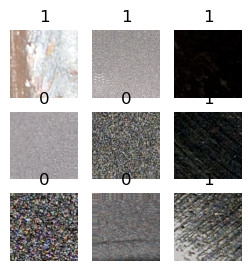

In [84]:
# Change the path so it fits your local directory
data_dir = '/Users/jesselemeer/Documents/GitHub/quality-control/linsen_data/train'

image_size = (512,512)

train_data, val_data = keras.utils.image_dataset_from_directory(
    data_dir,
    labels="inferred",
    validation_split=0.2,
    subset="both",
    seed=6568,
    color_mode="rgb",
    batch_size=32,
    image_size=image_size,
    shuffle=True,
)

# Augmenting the data to introduce more variety in the training data
data_augmentation = tf.keras.Sequential([
    layers.RandomFlip("horizontal_and_vertical"),
    layers.RandomRotation(0.3),
    layers.RandomZoom(0.3),
    layers.RandomContrast(0.2),
    layers.RandomBrightness(0.2),
    layers.RandomTranslation(0.1, 0.1),
    layers.RandomCrop(450, 450),
    layers.Resizing(512, 512)
])

train_data = train_data.map(lambda x, y: (data_augmentation(x, training=True), y))

# Printing the images
plt.figure(figsize=(3, 3))
for images, labels in train_data.take(1):
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(np.array(images[i]).astype("uint8"))
        plt.title(int(labels[i]))
        plt.axis("off")

def normalize_data(data, label):
    data = tf.cast(data, tf.float32) / 255.0
    return data, label

def preprocess_data(data, label):
    data = preprocess_input(tf.cast(data, tf.float32))
    return data, label

data_augmentation = tf.keras.Sequential([
    layers.RandomFlip("horizontal_and_vertical"),
    layers.RandomRotation(0.2), 
    layers.RandomZoom(0.2), 
    layers.RandomContrast(0.1), 
    
])

# Apply data augmentation to training data
train_data = train_data.map(lambda x, y: (data_augmentation(x, training=True), y))

train_data = train_data.map(normalize_data)
val_data = val_data.map(normalize_data)

model = Sequential([
    # First Convolutional Block
    layers.Conv2D(32, (3, 3), activation='relu', input_shape=(512, 512, 3)),
    layers.BatchNormalization(),
    layers.MaxPooling2D((2, 2)),

    # Second Convolutional Block
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.BatchNormalization(),
    layers.MaxPooling2D((2, 2)),

    # Third Convolutional Block
    layers.Conv2D(128, (3, 3), activation='relu'),
    layers.BatchNormalization(),
    layers.MaxPooling2D((2, 2)),

    # Attention Layer (optional)
    layers.GlobalAveragePooling2D(),
    # Fully Connected Layer
    layers.Dense(128, activation='relu', kernel_regularizer=regularizers.l2(0.001)),
    layers.BatchNormalization(),
    layers.Dropout(0.6),

    # Output Layer
    layers.Dense(1, activation='sigmoid')
])

# optimizer='adam'
optimizer=Adam(learning_rate=0.0005) #Standard 'adam' has 0.001 LR, 

model.compile(optimizer=optimizer,
                loss=tf.keras.losses.BinaryCrossentropy(),
                metrics=['accuracy'])
print(model.summary())


Epoch 1/30
36/36 [==============================] - 226s 6s/step - loss: 0.7823 - accuracy: 0.7020 - val_loss: 0.8259 - val_accuracy: 0.4286 - lr: 5.0000e-04
Epoch 2/30
36/36 [==============================] - 306s 8s/step - loss: 0.6566 - accuracy: 0.7696 - val_loss: 0.9030 - val_accuracy: 0.4286 - lr: 5.0000e-04
Epoch 3/30
36/36 [==============================] - ETA: 0s - loss: 0.7172 - accuracy: 0.7375
Epoch 3: ReduceLROnPlateau reducing learning rate to 0.0002500000118743628.
36/36 [==============================] - 291s 8s/step - loss: 0.7172 - accuracy: 0.7375 - val_loss: 0.8783 - val_accuracy: 0.4286 - lr: 5.0000e-04
Epoch 4/30
36/36 [==============================] - 324s 9s/step - loss: 0.6528 - accuracy: 0.7651 - val_loss: 0.9007 - val_accuracy: 0.4286 - lr: 2.5000e-04
Epoch 5/30
36/36 [==============================] - ETA: 0s - loss: 0.6022 - accuracy: 0.7900
Epoch 5: ReduceLROnPlateau reducing learning rate to 0.0001250000059371814.
36/36 [==============================] 

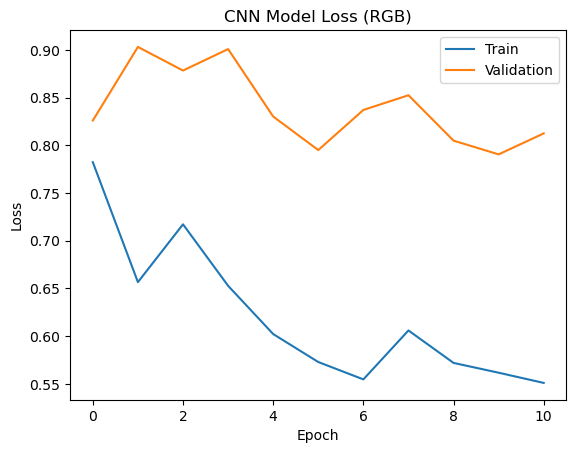

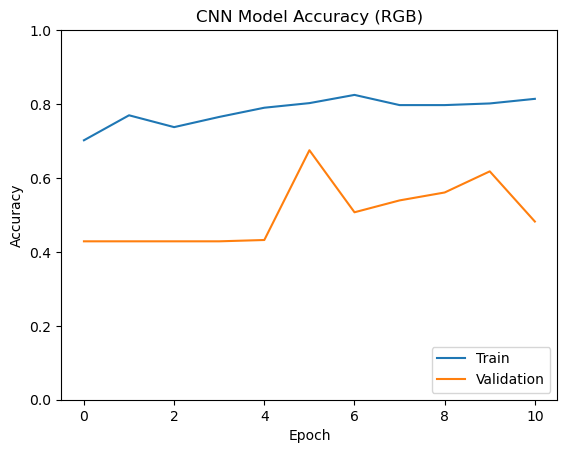

In [85]:
# Change name before training!
epochs = 30

callbacks = [
    keras.callbacks.ModelCheckpoint(
        filepath="SR_T8_DataAug_OptParam_BW2_Dropout0.6_L-Data_512_E{epoch}.keras",
        save_weights_only=False,    # Ensure both weights and model architecture are saved
    ), 
    keras.callbacks.EarlyStopping(
        monitor= 'val_accuracy',    
        patience=5,                 # Stop after 4 epochs of no improvement
        restore_best_weights=True   
    ),
    keras.callbacks.ReduceLROnPlateau(
        monitor='val_loss',         # Monitor validation loss
        factor=0.5,                 # Halves the learning rate when no improvement
        patience=2,                 # Reduce learning rate after 2 epochs of no improvement
        verbose=1,                  # Prints message when no improvement
        min_lr=1e-6,                # Minimum learning rate
        min_delta=0.001             # Minimum change of validation loss
)
]

history = model.fit(
    train_data,
    epochs=epochs,
    callbacks=callbacks,
    validation_data=val_data
)

current_description = '(RGB)'
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('CNN Model Loss ' + current_description)
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper right')
plt.show()

plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('CNN Model Accuracy ' + current_description)
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='lower right')
plt.ylim(0, 1)
plt.show()

# Note: the output below is not the training from the final model, those plots can be seen in the report

In [5]:
test_path = '/Users/jesselemeer/Documents/GitHub/quality-control/linsen_data/test'

import os
import numpy as np
import tensorflow as tf
from tensorflow.keras.preprocessing.image import img_to_array, load_img
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from tensorflow.keras.models import load_model

# Path to your trained model, change it so it fits your local directory
model_path = '/Users/jesselemeer/Documents/GitHub/quality-control/models/CNN/SR_FourthTry_DataAug_OptParam_BW2_Dropout0.6_L-Data_512_E24.keras'

# Load the trained model
model = load_model(model_path)

# Function to preprocess a single image
def preprocess_image(image_path):
    img = load_img(image_path)  
    img_array = img_to_array(img)  
    img_array = img_array / 255.0  # nomrmalise
    img_array = tf.expand_dims(img_array, axis=0)  
    return img_array


def load_images_and_labels(folder_path):
    images = []
    labels = []
    file_names = []
    for label, subfolder in enumerate(['good', 'not-good']):  # good = 0, not-good = 1
        subfolder_path = os.path.join(folder_path, subfolder)
        for filename in os.listdir(subfolder_path):
            if filename.endswith('.jpg') or filename.endswith('.png'):  # Valid image files
                image_path = os.path.join(subfolder_path, filename)
                img_array = preprocess_image(image_path)
                images.append(img_array)
                labels.append(label)
                file_names.append(filename)
    return np.vstack(images), np.array(labels), file_names


x_test, y_true, file_names = load_images_and_labels(test_path)

y_pred_prob = model.predict(x_test) 
y_pred = (y_pred_prob > 0.5).astype(int).flatten()  # Convert probabilities to binary predictions, threshold = 0.5. This can be varied 

print("Predictions for each file:")
for file_name, prob, pred, true_label in zip(file_names, y_pred_prob.flatten(), y_pred, y_true):
    print(f"File: {file_name}, Probability: {prob:.4f}, Predicted: {pred}, True Label: {true_label}")


accuracy = accuracy_score(y_true, y_pred)
precision = precision_score(y_true, y_pred)
recall = recall_score(y_true, y_pred)
f1 = f1_score(y_true, y_pred)


print(f"Accuracy: {accuracy:.2f}")
print(f"Precision: {precision:.2f}")
print(f"Recall: {recall:.2f}")
print(f"F1 Score: {f1:.2f}")

8/8 [==============================] - 12s 1s/step
Predictions for each file:
File: slice009_014.png, Probability: 0.0040, Predicted: 0, True Label: 0
File: slice019_014.png, Probability: 0.0475, Predicted: 0, True Label: 0
File: slice022_009.png, Probability: 0.0528, Predicted: 0, True Label: 0
File: slice008_005.png, Probability: 0.0071, Predicted: 0, True Label: 0
File: slice011_006.png, Probability: 0.4473, Predicted: 0, True Label: 0
File: slice040_008.png, Probability: 0.0440, Predicted: 0, True Label: 0
File: slice000_002.png, Probability: 0.0050, Predicted: 0, True Label: 0
File: slice008_004.png, Probability: 0.0814, Predicted: 0, True Label: 0
File: slice009_001.png, Probability: 0.0055, Predicted: 0, True Label: 0
File: slice022_008.png, Probability: 0.2480, Predicted: 0, True Label: 0
File: slice004_008.png, Probability: 0.0061, Predicted: 0, True Label: 0
File: slice018_006.png, Probability: 0.0115, Predicted: 0, True Label: 0
File: slice027_007.png, Probability: 0.2441, P